In [1]:
import pandas as pd #Must be using an older version of Pandas due to compatability issues with the anomaly detectors
import matplotlib.pyplot as plt
import numpy as np

#Anomaly detection:
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD
'''Detector that detects anomaly based on values in a preceding period.

This detector compares time series values with the values of their preceding time windows,
and identifies a time point as anomalous if the change of value from its preceding average
 or median is anomalously large.
 '''

'Detector that detects anomaly based on values in a preceding period.\n\nThis detector compares time series values with the values of their preceding time windows,\nand identifies a time point as anomalous if the change of value from its preceding average\n or median is anomalously large.\n '

### Regional PBA account

In [2]:
D_pba_reg = pd.read_csv('summary\D_pba_reg.csv',sep='\t',index_col=[0])

In [3]:
D_pba_reg_column_names = list(D_pba_reg.columns)
display(D_pba_reg_column_names[-12:-1]) #displaying compiled stressor columns

['Total CO2',
 'Total CH4',
 'Total N2O',
 'Total SOx',
 'Total PM10',
 'Total PM2.5',
 'Total Water Consumption Blue',
 'Total Domestic Extraction Used',
 'Total Land Use',
 'Value Added',
 'Total Employment Hours']

Only index-by-index classification is used.

In [4]:
''' Industry by industry dataframe '''
D_pba_reg_ixi = D_pba_reg.loc[D_pba_reg['system'] == 'ixi']

Producing time-series Dataframes for any region:

In [5]:
''' The function produces a dataframe of a region's stressors for the time frame available (1995-2022). '''
def time_series(pba, region):
    df = pba.loc[pba['region'] == region] #cba being either the pxp or ixi dataframe
    return df

In [6]:
#Global
D_pba_GLOBAL = time_series(D_pba_reg_ixi,'global')

#The United States:
D_pba_USA = time_series(D_pba_reg_ixi,'US')

#The EU
D_pba_EU27 = time_series(D_pba_reg_ixi,'EU27')

#China
D_pba_CHINA = time_series(D_pba_reg_ixi,'CN') #In exiobase CH is the code for Switzerland. CN is China!

In [7]:
#Normalization function, used throughout the analysis
def normalize(time_series, ref_point):
    return time_series/ref_point #ref point is supposed to be 1995

#### Anomaly detection setup:

In [8]:
#The detection package is depentant on DatetimeIndex, so years must be converted to that object type
global_co2 = D_pba_GLOBAL.loc[:,'Total CO2'].to_numpy()
date_time_years = pd.to_datetime(D_pba_GLOBAL.index, format='%Y')

In [9]:
#This is the module used for the anomaly detection
#(from documentation) By default PersistAD only checks one previous value, 
#which is good at capturing additive anomaly in short-term scale, but not in long-term scale because it is too near-sighted.
persist_ad = PersistAD(c=1) #c --> factor used to determine the bound of normal range based on historical interquartile range

Defining general anomaly detection plotters:

In [10]:
#Incase you only need the anomaly
def detect_anomaly(impact):
    glob = pd.DataFrame(D_pba_GLOBAL.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', the world'])
    Usa = pd.DataFrame(D_pba_USA.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', USA'])
    Eu = pd.DataFrame(D_pba_EU27.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', EU27'])
    China = pd.DataFrame(D_pba_CHINA.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', China'])

    glob = validate_series(glob)
    Usa = validate_series(Usa)
    Eu = validate_series(Eu)
    China = validate_series(China)

    an_global = persist_ad.fit_detect(glob)
    an_USA = persist_ad.fit_detect(Usa)
    an_Eu = persist_ad.fit_detect(Eu)
    an_China = persist_ad.fit_detect(China)

    return an_global, an_USA, an_Eu, an_China

First, detect anomalies and map out when they occur.

Second, determine the scale of the anomaly detected. Present data concisely.

In [11]:
#Detected anomalies are dataframes containing boolean values. 
#TRUE if an anomaly is detected & FALSE if no anomaly is present.
anom_co2global, anom_co2US, anom_co2EU, anom_co2China = detect_anomaly('Total CO2')
co2anoms = pd.concat([anom_co2global,anom_co2US,anom_co2EU,anom_co2China],axis=1)

anom_landglobal, anom_landUS, anom_landEU, anom_landChina = detect_anomaly('Total Land Use')
landanoms = pd.concat([anom_landglobal,anom_landUS,anom_landEU,anom_landChina],axis=1)

anom_wglobal, anom_wUS, anom_wEU, anom_wChina = detect_anomaly('Total Water Consumption Blue')
wateranoms = pd.concat([anom_wglobal,anom_wUS,anom_wEU,anom_wChina],axis=1)

anom_mglobal, anom_mUS, anom_mEU, anom_mChina = detect_anomaly('Total Domestic Extraction Used')
materialanoms = pd.concat([anom_mglobal,anom_mUS,anom_mEU,anom_mChina],axis=1)
#This is to export the anomalies to an Excel file so I can create a comparable anomaly table.
#Should stay commented out to preserve the Excel sheet

#because I want several sheets (mode a appends to an existing Excel file):
'''with pd.ExcelWriter('anomaly_table.xlsx', mode='a') as writer:
    co2anoms.to_excel(writer, sheet_name='PBA_CO2')
    landanoms.to_excel(writer, sheet_name='PBA_land')
    wateranoms.to_excel(writer, sheet_name='PBA_water')
    materialanoms.to_excel(writer, sheet_name='PBA_material')'''

"with pd.ExcelWriter('anomaly_table.xlsx', mode='a') as writer:\n    co2anoms.to_excel(writer, sheet_name='PBA_CO2')\n    landanoms.to_excel(writer, sheet_name='PBA_land')\n    wateranoms.to_excel(writer, sheet_name='PBA_water')\n    materialanoms.to_excel(writer, sheet_name='PBA_material')"

In [12]:
#Determining some measure of the scale of the effect.
def anomaly_scale(time_series):
    #This function takes in the time-series and its equivalent anomaly list
    #and creates another dataframe containing the scale of the anomaly
    time_series = validate_series(time_series)

    an_ts = persist_ad.fit_detect(time_series).to_numpy()
    dt_ts = time_series.diff().to_numpy()

    an_scales = pd.DataFrame(np.zeros(len(time_series)), index= date_time_years, columns=time_series.columns)

    for i in range(len(dt_ts)):
        if (an_ts[i] == True):
            an_scales.iloc[i] = dt_ts[i]
    
    return an_scales

In [13]:
def impact_an_scales(impact):
    glob = anomaly_scale(pd.DataFrame(D_pba_GLOBAL.loc[:,impact].to_numpy(),index=date_time_years,columns=['The World']))
    usa = anomaly_scale(pd.DataFrame(D_pba_USA.loc[:,impact].to_numpy(),index=date_time_years,columns=['USA']))
    eu27 = anomaly_scale(pd.DataFrame(D_pba_EU27.loc[:,impact].to_numpy(),index=date_time_years,columns=['EU27']))
    china = anomaly_scale(pd.DataFrame(D_pba_CHINA.loc[:,impact].to_numpy(),index=date_time_years,columns=['China']))

    combined = pd.concat([glob,usa,eu27,china], axis=1)

    return combined

CO2_an_scales = impact_an_scales('Total CO2')
land_an_scales = impact_an_scales('Total Land Use')
water_an_scales = impact_an_scales('Total Water Consumption Blue')
material_an_scales = impact_an_scales('Total Domestic Extraction Used')

In [15]:
'''with pd.ExcelWriter('anomaly_scales.xlsx', mode='a') as writer:
    CO2_an_scales.to_excel(writer, sheet_name='PBA_CO2')
    land_an_scales.to_excel(writer, sheet_name='PBA_land')
    water_an_scales.to_excel(writer, sheet_name='PBA_water')
    material_an_scales.to_excel(writer, sheet_name='PBA_material')'''

"with pd.ExcelWriter('anomaly_scales.xlsx', mode='a') as writer:\n    CO2_an_scales.to_excel(writer, sheet_name='PBA_CO2')\n    land_an_scales.to_excel(writer, sheet_name='PBA_land')\n    water_an_scales.to_excel(writer, sheet_name='PBA_water')\n    material_an_scales.to_excel(writer, sheet_name='PBA_material')"

The footprints that are primarily of interest are:
-  Global warming footprint
-  Water use footprint
-  Land use footprint
-  Material use footprint

While these plot functions are no longer used for the final edition of the analysis, they are not deleted. General plot functions can be defined to make plotting data easier:

In [19]:
#Normalized plot function (to initial 1995 values)
def plot_norm_footprint(input, footprint, plot_title, color):
    norm = normalize(input.loc[:,footprint], input.loc[1995,footprint])

    #All 2022 rows have the value 0 for 'Total Land Use'. This makes clearer plots:
    if (footprint == 'Total Land Use'):
        norm = norm.iloc[:-1]

    norm.plot(title = plot_title, color=color)

    #Setting limits
    min_val = normalize(input.loc[:,footprint], input.loc[1995,footprint].min()).min()
    lower_lim = 0.9
    if (lower_lim >= min_val): #incase normalized values exceed predetermined lower limit
        lower_lim = min_val*0.9
    else:
        lower_lim = lower_lim    
    upper_lim = (normalize(input.loc[:,footprint], input.loc[1995,footprint]).max())*1.1
    plt.ylim((lower_lim,upper_lim))

    plt.axvline(x=1997, color='lightgray', linestyle='--',label='Asian financial crisis')
    plt.axvline(x=2001, color='lightgray', linestyle='--',label='Dotcom bubble')
    plt.axvline(x=2007, color='lightgray', linestyle='--',label='Global financial crisis')
    plt.axvline(x=2020, color='lightgray', linestyle='--',label='COVID-19 pandemic')

    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = True

    plt.xlabel('year')

In [20]:
#Normalized plot function (to initial 1995 values) to plot regional (USE, EU27 and China) impacts on same figure
def plot_norm_reg_footprint(footprint, plot_title):
    norm1 = normalize(D_pba_USA.loc[:,footprint], D_pba_USA.loc[1995,footprint])
    norm2 = normalize(D_pba_EU27.loc[:,footprint], D_pba_EU27.loc[1995,footprint])
    norm3 = normalize(D_pba_CHINA.loc[:,footprint], D_pba_CHINA.loc[1995,footprint])

    norm1 = norm1.rename('USA')
    norm2 = norm2.rename('EU27')
    norm3 = norm3.rename('China')

    #All 2022 rows have the value 0 for 'Total Land Use'. This makes clearer plots:
    if (footprint == 'Total Land Use'):
        norm1 = norm1.iloc[:-1]
        norm2 = norm2.iloc[:-1]
        norm3 = norm3.iloc[:-1]

    norm1.plot(title = plot_title, color='tab:green')
    norm2.plot(color='tab:orange')
    norm3.plot(color='tab:blue')

    plt.legend()

    plt.axvline(x=1997, color='lightgray', linestyle='--',label='Asian financial crisis')
    plt.axvline(x=2001, color='lightgray', linestyle='--',label='Dotcom bubble')
    plt.axvline(x=2007, color='lightgray', linestyle='--',label='Global financial crisis')
    plt.axvline(x=2020, color='lightgray', linestyle='--',label='COVID-19 pandemic')

    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = True

    plt.xlabel('year')

### Plotting for <span style='color:red'> Global warming PBA account</span>: 
(for now just CO2 emissions)

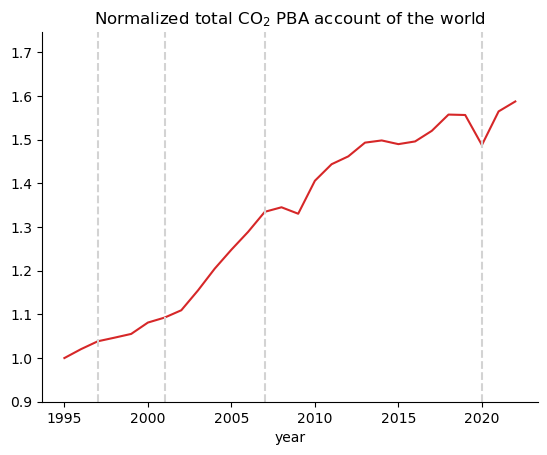

In [21]:
plot_norm_footprint(D_pba_GLOBAL, 'Total CO2', 'Normalized total CO$_2$ PBA account of the world', 'tab:red')

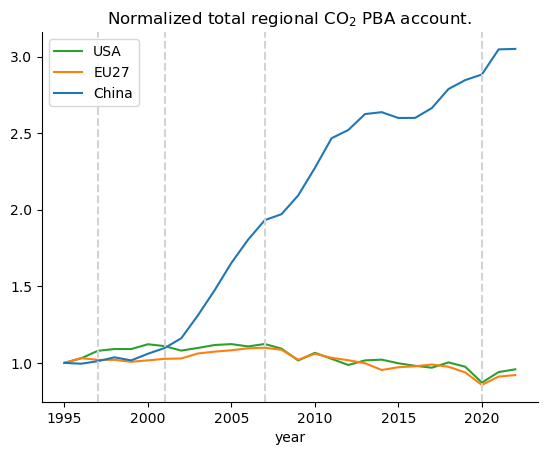

In [22]:
plot_norm_reg_footprint('Total CO2', 'Normalized total regional CO$_2$ PBA account.')

### Plotting for <span style='color:red'> Land use PBA account </span>:

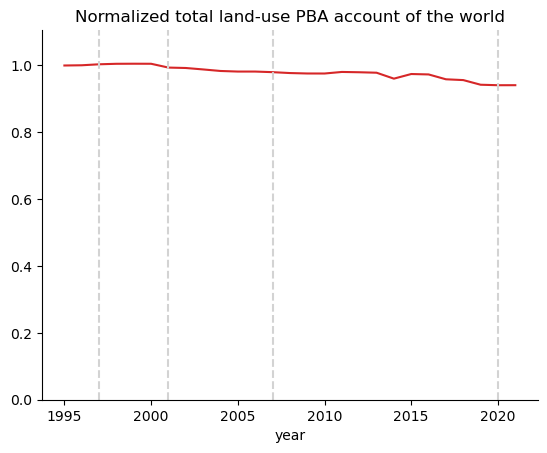

In [23]:
plot_norm_footprint(D_pba_GLOBAL, 'Total Land Use', 'Normalized total land-use PBA account of the world', 'tab:red')

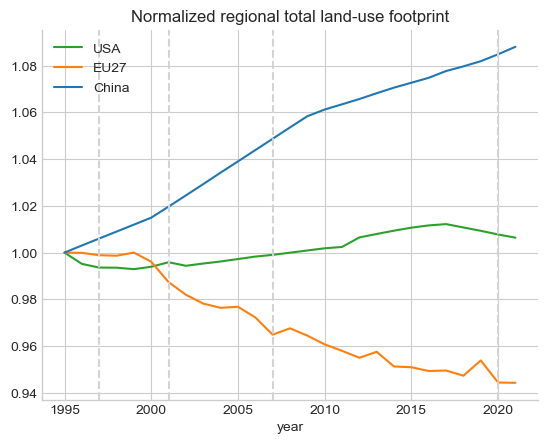

In [73]:
plot_norm_reg_footprint('Total Land Use', 'Normalized regional total land-use footprint')

### Plotting for <span style='color:red'> Water use PBA account </span>:

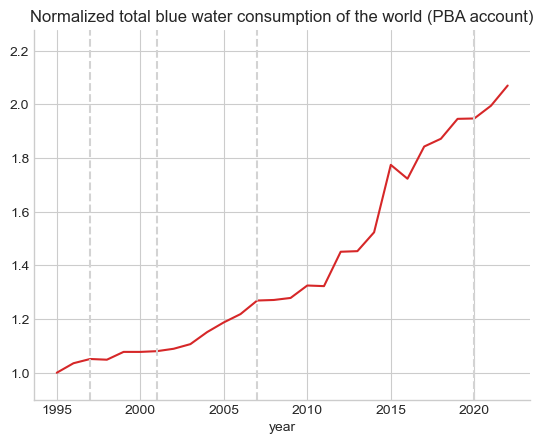

In [76]:
plot_norm_footprint(D_pba_GLOBAL, 'Total Water Consumption Blue', 'Normalized total blue water consumption of the world (PBA account)', 'tab:red')

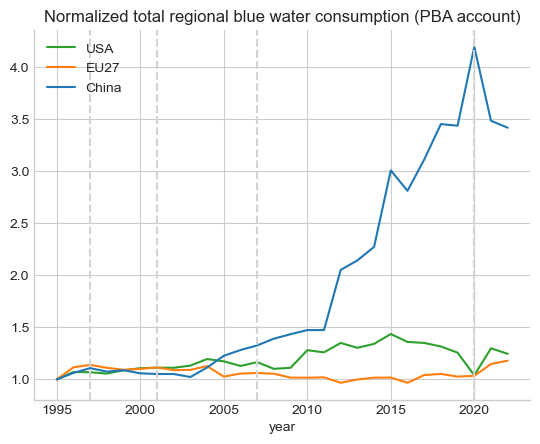

In [77]:
plot_norm_reg_footprint('Total Water Consumption Blue', 'Normalized total regional blue water consumption (PBA account)')

### Plotting for <span style='color:red'> Material use PBA account </span>:

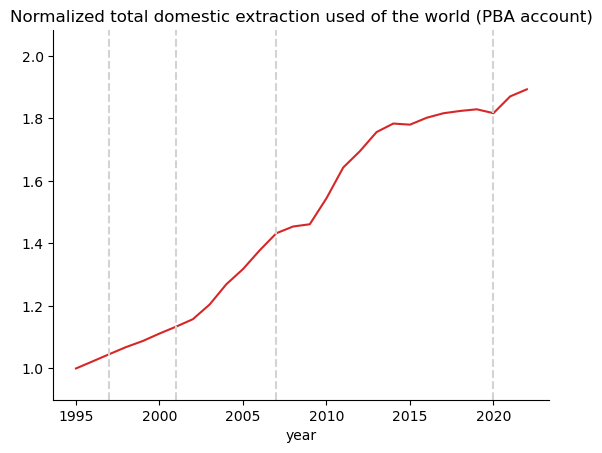

In [24]:
plot_norm_footprint(D_pba_GLOBAL, 'Total Domestic Extraction Used', 'Normalized total domestic extraction used of the world (PBA account)', 'tab:red')

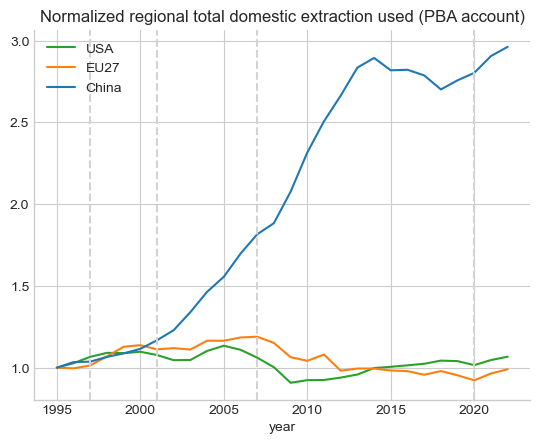

In [81]:
plot_norm_reg_footprint('Total Domestic Extraction Used', 'Normalized regional total domestic extraction used (PBA account)')